# First approach on Leukemia Study

### TCGA Dataset - The Cancer Genome Atlas Program

The file to analyse 4e2f3a20-e8a2-4711-995a-c97261572dc3.rna_seq.augmented_star_gene_counts.tsv is a gene expression quantification file from RNA-Seq data.
It contains gene counts data from the TARGET-AML project. The data is from a primary blood-derived cancer bone marrow sample, processed using the STAR-Counts workflow.

The reference genome used was GRCh38.p0

Research datasets found on https://www.cancer.gov/ccg/access-data


In [1]:
import pandas as pd
import json
import os
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

file_path = os.path.join(
    "..", "data", "b11b5fbe-8e5e-402d-9a14-cd2656beb88c_history.2024-10-05.json"
)

# Reading the metadata from a JSON file
try:
    with open(file_path, "r") as file:
        data = json.load(file)

    print("File contents:")
    print(json.dumps(data, indent=2))

    for item in data:
        print(item)

except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
except json.JSONDecodeError:
    print(f"Error: The file '{file_path}' does not contain valid JSON.")
except Exception as e:
    print(f"An error occurred: {str(e)}")

File contents:
[
  {
    "uuid": "b11b5fbe-8e5e-402d-9a14-cd2656beb88c",
    "version": "1",
    "file_change": "released",
    "release_date": "2022-09-28",
    "data_release": "35.0"
  }
]
{'uuid': 'b11b5fbe-8e5e-402d-9a14-cd2656beb88c', 'version': '1', 'file_change': 'released', 'release_date': '2022-09-28', 'data_release': '35.0'}


In [2]:
file_path = os.path.join(
    "..", "data", "c97261572dc3.rna_seq.augmented_star_gene_counts.tsv"
)

df = pd.read_csv(file_path, sep="\t", header=0, skiprows=1)
numeric_columns = [
    "unstranded",
    "stranded_first",
    "stranded_second",
    "tpm_unstranded",
    "fpkm_unstranded",
    "fpkm_uq_unstranded",
]

# Applying conversion to numeric, forcing non-numeric values to NaN
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors="coerce")

# Delete rows with NaN in the gene_name column
df.dropna(subset=["gene_name"], inplace=True)
print(df.head())

              gene_id gene_name       gene_type  unstranded  stranded_first  \
4  ENSG00000000003.15    TSPAN6  protein_coding           3               1   
5   ENSG00000000005.6      TNMD  protein_coding           0               0   
6  ENSG00000000419.13      DPM1  protein_coding         358               3   
7  ENSG00000000457.14     SCYL3  protein_coding         759             249   
8  ENSG00000000460.17  C1orf112  protein_coding         434             172   

   stranded_second  tpm_unstranded  fpkm_unstranded  fpkm_uq_unstranded  
4                2          0.0807           0.0225              0.0212  
5                0          0.0000           0.0000              0.0000  
6              360         36.2052          10.0711              9.5158  
7              797         13.4604           3.7442              3.5378  
8              566          8.8738           2.4684              2.3323  


# Variables in the dataset
- gene_id: A unique identifier for each gene (ENSG).
- gene_name: Name of the gene (e.g., TSPAN6, TNMD).
- gene_type: The type of gene (e.g., protein-coding, pseudogene, lncRNA).

Expression Quantifications:
        - unstranded: Gene expression counts without strand-specific information.
        - stranded_first: Gene expression counts from the first strand.
        - stranded_second: Gene expression counts from the second strand.
        - tpm_unstranded: Transcripts Per Million (TPM) measure for unstranded reads.
        - fpkm_unstranded: Fragments Per Kilobase of transcript per Million mapped reads (FPKM).
        - fpkm_uq_unstranded: Upper quartile normalized FPKM.

In [3]:
print("\nDataFrame info:")
print(df.info())


DataFrame info:
<class 'pandas.core.frame.DataFrame'>
Index: 60660 entries, 4 to 60663
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gene_id             60660 non-null  object 
 1   gene_name           60660 non-null  object 
 2   gene_type           60660 non-null  object 
 3   unstranded          60660 non-null  int64  
 4   stranded_first      60660 non-null  int64  
 5   stranded_second     60660 non-null  int64  
 6   tpm_unstranded      60660 non-null  float64
 7   fpkm_unstranded     60660 non-null  float64
 8   fpkm_uq_unstranded  60660 non-null  float64
dtypes: float64(3), int64(3), object(3)
memory usage: 4.6+ MB
None


In [4]:
print("\nStats for numeric columns:")
print(df.describe())
print(
    f"\nNon-null count for each column: from a total of 60675 rows (in %) \n{df.count()/60675 * 100}"
)


Stats for numeric columns:
          unstranded  stranded_first  stranded_second  tpm_unstranded  \
count   60660.000000    60660.000000     60660.000000    60660.000000   
mean      523.527465       43.070986       531.010320       16.485328   
std      3634.349052      332.399391      3686.687441      483.287058   
min         0.000000        0.000000         0.000000        0.000000   
25%         0.000000        0.000000         0.000000        0.000000   
50%         3.000000        1.000000         1.000000        0.419500   
75%        68.000000        7.000000        37.000000        6.385675   
max    537940.000000    29292.000000    537366.000000   116154.570100   

       fpkm_unstranded  fpkm_uq_unstranded  
count     60660.000000        60660.000000  
mean          4.585677            4.332844  
std         134.434597          127.022487  
min           0.000000            0.000000  
25%           0.000000            0.000000  
50%           0.116700            0.110200  

In [5]:
# Count number of different types of gene types
print("\nCount of different types of gene types:")
print(df["gene_type"].value_counts())


Count of different types of gene types:
gene_type
protein_coding                        19962
lncRNA                                16901
processed_pseudogene                  10167
unprocessed_pseudogene                 2614
misc_RNA                               2212
snRNA                                  1901
miRNA                                  1881
TEC                                    1057
snoRNA                                  943
transcribed_unprocessed_pseudogene      939
transcribed_processed_pseudogene        500
rRNA_pseudogene                         497
IG_V_pseudogene                         187
IG_V_gene                               145
transcribed_unitary_pseudogene          138
TR_V_gene                               106
unitary_pseudogene                       98
TR_J_gene                                79
scaRNA                                   49
polymorphic_pseudogene                   48
rRNA                                     47
IG_D_gene                

# 1st Class and Goal Definition

Class 1: Protein-coding and Regulatory RNAs

    protein_coding
    lncRNA (long non-coding RNA)
    miRNA (microRNA)
    misc_RNA
    snRNA (small nuclear RNA)
    snoRNA (small nucleolar RNA)
    scaRNA (small Cajal body-specific RNA)

Class 2: Pseudogenes and Immunoglobulin/T-cell Receptor Genes

    processed_pseudogene
    unprocessed_pseudogene
    transcribed_unprocessed_pseudogene
    transcribed_processed_pseudogene
    unitary_pseudogene
    IG_V_pseudogene
    IG_V_gene
    TR_V_gene
    TR_J_gene
    IG_D_gene

Rationale for this grouping:

    Class 1 focuses on protein-coding genes and regulatory RNAs, which are often directly involved in gene expression regulation and cellular processes. In leukemia research, these gene types are crucial for understanding:
        Altered gene expression patterns in leukemic cells
        Dysregulation of key signaling pathways
        Potential therapeutic targets
        miRNA-mediated regulation of leukemia-associated genes
    Class 2 includes pseudogenes and immunoglobulin/T-cell receptor genes, which can provide insights into:
        Genomic instability in leukemic cells
        Potential biomarkers for leukemia subtypes
        Immune system involvement in leukemia progression and treatment response
        Clonal evolution of leukemic cells


Goals:
1. Identify correlations between protein-coding genes and regulatory RNAs that may be involved in leukemogenesis -> uncover novel relationships between different gene types in leukemia.
2. Explore the relationship between immunoglobulin/T-cell receptor gene expression and leukemia subtypes or treatment outcomes.

In [6]:
# Class 1: Protein-coding and Regulatory RNAs
class1_gene_types = [
    "protein_coding",
    "lncRNA",
    "miRNA",
    "misc_RNA",
    "snRNA",
    "snoRNA",
    "scaRNA",
]

# Class 2: Pseudogenes and Immunoglobulin/T-cell Receptor Genes
class2_gene_types = [
    "processed_pseudogene",
    "unprocessed_pseudogene",
    "transcribed_unprocessed_pseudogene",
    "transcribed_processed_pseudogene",
    "unitary_pseudogene",
    "IG_V_pseudogene",
    "IG_V_gene",
    "TR_V_gene",
    "TR_J_gene",
    "IG_D_gene",
]

In [7]:
class1_df = df[df["gene_type"].isin(class1_gene_types)]
class2_df = df[df["gene_type"].isin(class2_gene_types)]

class1_expression = class1_df[
    ["unstranded", "stranded_first", "stranded_second"]
].fillna(0)
class2_expression = class2_df[
    ["unstranded", "stranded_first", "stranded_second"]
].fillna(0)

# Step 1: standardize the data (should center as well but TODO according to paper's formula)
scaler = StandardScaler()
class1_scaled = scaler.fit_transform(class1_expression)
class2_scaled = scaler.fit_transform(class2_expression)

In [8]:
# Count number of rows we are going to use
n = min(class1_scaled.shape[0], class2_scaled.shape[0])
print(f"Number of rows to use: {n}")

Number of rows to use: 14872


In [9]:
class1_df = pd.DataFrame(class1_scaled)
class2_df = pd.DataFrame(class2_scaled)

# Find the minimum number of rows between the two classes
min_samples = min(class1_df.shape[0], class2_df.shape[0])

# Slice both DataFrames to have the same number of samples
class1_df = class1_df.iloc[:min_samples, :]
class2_df = class2_df.iloc[:min_samples, :]

In [10]:
cca = CCA(n_components=2)
class1_cca, class2_cca = cca.fit_transform(class1_df, class2_df)

print("Canonical Correlation Coefficients for Class 1:\n", class1_cca[:10])
print("\nCanonical Correlation Coefficients for Class 2:\n", class2_cca[:10])

Canonical Correlation Coefficients for Class 1:
 [[-0.06835357 -0.06569601]
 [-0.06846627 -0.06492798]
 [-0.05125238 -0.05779175]
 [-0.07563731 -0.01969776]
 [-0.09115132  0.05200357]
 [ 0.0673354  -0.025904  ]
 [-0.06722485 -0.06449135]
 [-0.08522807  0.09432384]
 [ 0.00796702  0.37111855]
 [-0.04139355  0.01933746]]

Canonical Correlation Coefficients for Class 2:
 [[ 0.10330177 -0.0060199 ]
 [ 0.07305129  0.00591962]
 [ 0.09995982 -0.00806752]
 [-0.09007191 -0.09636265]
 [ 0.09828884 -0.00909134]
 [-0.23396066 -5.57360881]
 [-3.39559699  1.01059908]
 [-0.51835892 -0.37675562]
 [-2.47340077 -1.57461685]
 [-0.13421686 -0.2288492 ]]


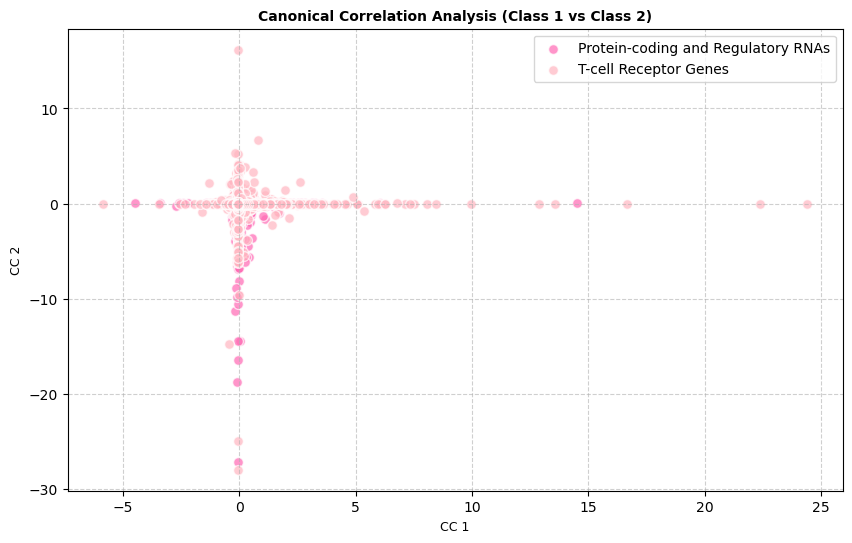

In [11]:
plt.figure(figsize=(10, 6))

plt.scatter(
    class1_cca[:, 0],
    class2_cca[:, 0],
    label="Protein-coding and Regulatory RNAs",
    color="hotpink",
    s=50,
    alpha=0.7,
    edgecolors="w",
)
plt.scatter(
    class1_cca[:, 1],
    class2_cca[:, 1],
    label="T-cell Receptor Genes",
    color="lightpink",
    s=50,
    alpha=0.7,
    edgecolors="w",
)
plt.grid(True, linestyle="--", alpha=0.6)
plt.title(
    "Canonical Correlation Analysis (Class 1 vs Class 2)",
    fontsize=10,
    fontweight="bold",
)

plt.xlabel("CC 1", fontsize=9)
plt.ylabel("CC 2", fontsize=9)

plt.legend()
plt.show()

The correlation coefficients found is not big enough to draw useful insights. We now try another class separation criteria.

## 2nd Class and Goal Definition practice
High vs. Low Expression Genes classification. This could help identify groups of genes that are more actively expressed versus those that are less involved in the cellular processes.
1. High Expression Genes: Genes above a certain expression threshold (e.g., top 25%).
2. Low Expression Genes: Genes below a certain expression threshold (e.g., bottom 25%).

Class 1: High Expressed Genes count: 30330
Class 2: Low Expressed Genes count: 30330


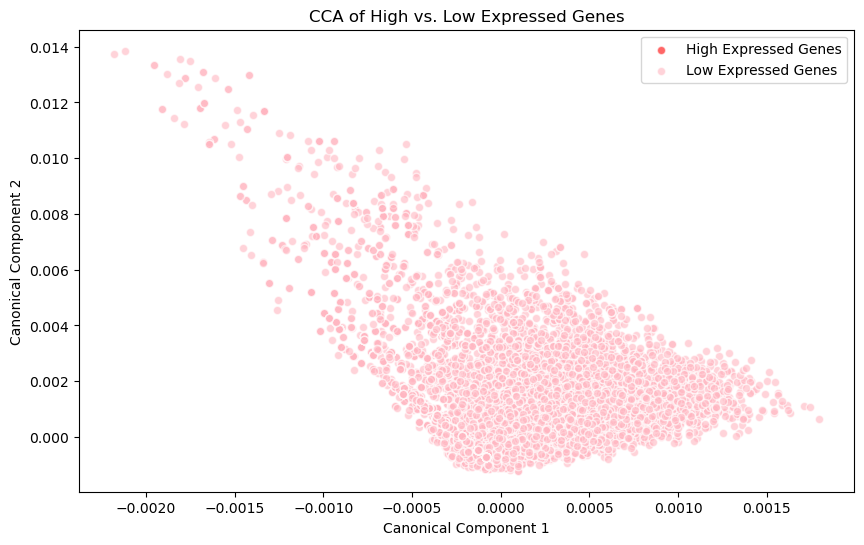

In [12]:
df["mean_expression"] = df[numeric_columns].mean(axis=1)

# Define a threshold to separate high and low expressed genes (e.g., median)
threshold = df["mean_expression"].median()

class1_high = df[df["mean_expression"] > threshold]
class2_low = df[df["mean_expression"] <= threshold]

print(f"Class 1: High Expressed Genes count: {len(class1_high)}")
print(f"Class 2: Low Expressed Genes count: {len(class2_low)}")

scaler = StandardScaler()
class1_scaled = scaler.fit_transform(class1_high[numeric_columns])
class2_scaled = scaler.fit_transform(class2_low[numeric_columns])

cca = CCA(n_components=2)
class1_cca, class2_cca = cca.fit_transform(class1_scaled, class2_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(
    class1_cca[:, 0],
    class1_cca[:, 1],
    color="red",
    label="High Expressed Genes",
    alpha=0.6,
    edgecolors="w",
)
plt.scatter(
    class2_cca[:, 0],
    class2_cca[:, 1],
    color="lightpink",
    label="Low Expressed Genes",
    alpha=0.6,
    edgecolors="w",
)
plt.xlabel("Canonical Component 1")
plt.ylabel("Canonical Component 2")
plt.title("CCA of High vs. Low Expressed Genes")
plt.legend()
plt.show()

In [13]:
print("Canonical Correlation Coefficients for Class 1:\n", class1_cca[:10])
print("\nCanonical Correlation Coefficients for Class 2:\n", class2_cca[:10])

Canonical Correlation Coefficients for Class 1:
 [[-1.22094242e-07 -1.16628674e-07]
 [-3.15297866e-07  1.02047981e-07]
 [-1.71358098e-07 -2.77845099e-08]
 [ 5.44502618e-07  6.59649387e-08]
 [-3.91379876e-07  2.45780731e-07]
 [-2.44316953e-07 -1.55084815e-07]
 [ 4.17069671e-07  9.66584978e-08]
 [ 1.46090414e-07 -2.38107912e-07]
 [-8.53935510e-08 -1.71916011e-07]
 [ 2.16731488e-07  6.62397338e-08]]

Canonical Correlation Coefficients for Class 2:
 [[ 6.25554805e-04  1.92332431e-04]
 [-8.13741535e-05 -7.05356713e-04]
 [-1.04691573e-04 -3.57661082e-04]
 [-8.13741535e-05 -7.05356713e-04]
 [ 1.20169862e-03  2.11498428e-03]
 [ 3.42824170e-04 -6.29213393e-04]
 [ 5.97441875e-04  5.92816447e-04]
 [ 1.73831086e-04 -4.13165696e-04]
 [-8.13741535e-05 -7.05356713e-04]
 [ 3.18939060e-04  9.21673159e-04]]


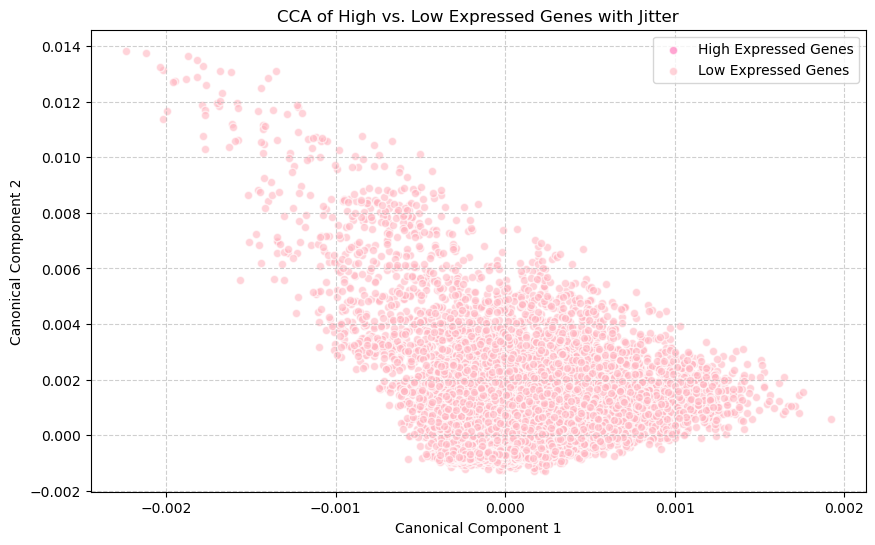

In [14]:
# Add jitter to the CCA outputs for better visualization
jitter_strength = 0.0001
class1_cca_jittered = class1_cca + np.random.normal(
    0, jitter_strength, class1_cca.shape
)
class2_cca_jittered = class2_cca + np.random.normal(
    0, jitter_strength, class2_cca.shape
)

plt.figure(figsize=(10, 6))
plt.scatter(
    class1_cca_jittered[:, 0],
    class1_cca_jittered[:, 1],
    color="hotpink",
    label="High Expressed Genes",
    alpha=0.6,
    edgecolors="w",
)
plt.scatter(
    class2_cca_jittered[:, 0],
    class2_cca_jittered[:, 1],
    color="lightpink",
    label="Low Expressed Genes",
    alpha=0.6,
    edgecolors="w",
)
plt.xlabel("Canonical Component 1")
plt.ylabel("Canonical Component 2")
plt.title("CCA of High vs. Low Expressed Genes with Jitter")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

coefficients are close to zero -> there is little correlation between the two classes. 
Reasons?

no variability: If the majority of genes in Class 1 have very similar expression levels, this can lead to low canonical correlations ?

feature selection: The selected features (gene types) might not be informative enough to show meaningful correlations ?

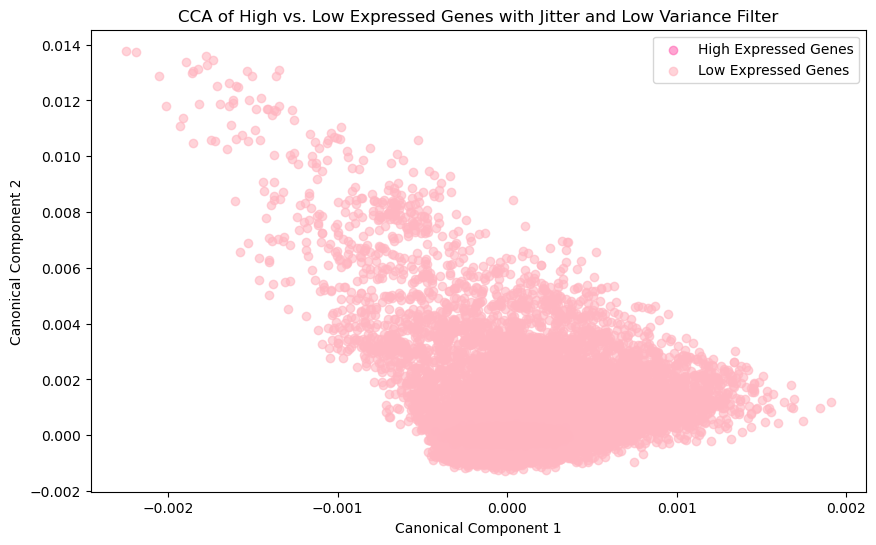

In [15]:
# Step 1: Remove low variance genes
from sklearn.feature_selection import VarianceThreshold

variance_threshold = VarianceThreshold(threshold=1e-4)
class1_high_filtered = variance_threshold.fit_transform(class1_high[numeric_columns])
class2_low_filtered = variance_threshold.fit_transform(class2_low[numeric_columns])

# Step 2: Perform CCA on the filtered data
cca = CCA(n_components=2)
class1_cca, class2_cca = cca.fit_transform(class1_high_filtered, class2_low_filtered)

# Step 3: Add jitter to the plot for better visualization
class1_cca_jittered = class1_cca + np.random.normal(
    0, jitter_strength, class1_cca.shape
)
class2_cca_jittered = class2_cca + np.random.normal(
    0, jitter_strength, class2_cca.shape
)

# Step 4: Plot the results with jitter
plt.figure(figsize=(10, 6))
plt.scatter(
    class1_cca_jittered[:, 0],
    class1_cca_jittered[:, 1],
    color="hotpink",
    label="High Expressed Genes",
    alpha=0.6,
)
plt.scatter(
    class2_cca_jittered[:, 0],
    class2_cca_jittered[:, 1],
    color="lightpink",
    label="Low Expressed Genes",
    alpha=0.6,
)
plt.xlabel("Canonical Component 1")
plt.ylabel("Canonical Component 2")
plt.title("CCA of High vs. Low Expressed Genes with Jitter and Low Variance Filter")
plt.legend()
plt.show()

## 3rd Class and Goal Definition
Biological pathways are a series of actions among molecules in a cell. We classify:
1. Cell Cycle: Genes involved in the process of cell division and growth
2. Apoptosis: Genes that regulate programmed cell death
3. Signal Transduction: Genes that help transmit signals within cells

In [16]:
# We download the library to get the list of genes (KEGG: Kyoto Encyclopedia of Genes and Genomes)
import gseapy as gp

kegg_library = gp.get_library("KEGG_2021_Human")
# Each key in the dictionary represents a specific biological pathway or process from the KEGG database
print(list(kegg_library.keys()))
cell_cycle_genes = kegg_library["Cell cycle"]
apoptosis_genes = kegg_library["Apoptosis"]
# For signal transduction genes, there isn't a single "Signal Transduction" pathway. Instead, there are multiple signaling pathways.
signal_transduction_pathways = [
    "MAPK signaling pathway",
    "PI3K-Akt signaling pathway",
    "JAK-STAT signaling pathway",
    "NF-kappa B signaling pathway",
    "TNF signaling pathway",
    "HIF-1 signaling pathway",
    "Calcium signaling pathway",
    "cAMP signaling pathway",
    "cGMP-PKG signaling pathway",
    "Phospholipase D signaling pathway",
    "Sphingolipid signaling pathway",
    "Rap1 signaling pathway",
    "Ras signaling pathway",
]

signal_transduction_genes = set()
for pathway in signal_transduction_pathways:
    signal_transduction_genes.update(kegg_library[pathway])
signal_transduction_genes = list(signal_transduction_genes)

['ABC transporters', 'AGE-RAGE signaling pathway in diabetic complications', 'AMPK signaling pathway', 'Acute myeloid leukemia', 'Adherens junction', 'Adipocytokine signaling pathway', 'Adrenergic signaling in cardiomyocytes', 'African trypanosomiasis', 'Alanine, aspartate and glutamate metabolism', 'Alcoholism', 'Aldosterone synthesis and secretion', 'Aldosterone-regulated sodium reabsorption', 'Allograft rejection', 'Alzheimer disease', 'Amino sugar and nucleotide sugar metabolism', 'Aminoacyl-tRNA biosynthesis', 'Amoebiasis', 'Amphetamine addiction', 'Amyotrophic lateral sclerosis', 'Antigen processing and presentation', 'Apelin signaling pathway', 'Apoptosis', 'Arachidonic acid metabolism', 'Arginine and proline metabolism', 'Arginine biosynthesis', 'Arrhythmogenic right ventricular cardiomyopathy', 'Ascorbate and aldarate metabolism', 'Asthma', 'Autoimmune thyroid disease', 'Autophagy', 'Axon guidance', 'B cell receptor signaling pathway', 'Bacterial invasion of epithelial cells',

In [17]:
# Extract from our dataset the genes that are part of the KEGG pathways
class1_genes = df[df["gene_name"].isin(cell_cycle_genes)]
class2_genes = df[df["gene_name"].isin(apoptosis_genes)]
class3_genes = df[df["gene_name"].isin(signal_transduction_genes)]
print(f"Number of cell cycle genes: {len(cell_cycle_genes)}")
print(f"Number of apoptosis genes: {len(apoptosis_genes)}")
print(f"Number of signal transduction genes: {len(signal_transduction_genes)}")

Number of cell cycle genes: 124
Number of apoptosis genes: 142
Number of signal transduction genes: 1291


In [18]:
# Function to prepare data for CCA
def prepare_data(gene_class):
    X = gene_class.drop(["gene_type"], axis=1, errors="ignore")
    X = X.select_dtypes(include=[np.number])  # Select only numeric columns
    return X.T  # Transpose the data so that genes are features and samples are rows


X1 = prepare_data(class1_genes)
X2 = prepare_data(class2_genes)
X3 = prepare_data(class3_genes)

In [19]:
# Ensure all datasets have the same number of samples
common_samples = list(set(X1.index) & set(X2.index) & set(X3.index))
X1 = X1.loc[common_samples]
X2 = X2.loc[common_samples]
X3 = X3.loc[common_samples]

In [20]:
# Standardize the data
scaler = StandardScaler()
X1_scaled = scaler.fit_transform(X1)
X2_scaled = scaler.fit_transform(X2)
X3_scaled = scaler.fit_transform(X3)

In [21]:
print(f"X1_scaled.shape is {X1_scaled.shape}")

X1_scaled.shape is (7, 124)


In [22]:
n_components = min(
    X1_scaled.shape[0] - 1, X1_scaled.shape[1], X2_scaled.shape[1], X3_scaled.shape[1]
)
print(f"Using {n_components} components for CCA")

cca_12 = CCA(n_components=n_components)
cca_12.fit(X1_scaled, X2_scaled)

cca_13 = CCA(n_components=n_components)
cca_13.fit(X1_scaled, X3_scaled)

cca_23 = CCA(n_components=n_components)
cca_23.fit(X2_scaled, X3_scaled)

Using 6 components for CCA


c:\Users\anaca\miniconda3\envs\cca_env_python\Lib\site-packages\sklearn\cross_decomposition\_pls.py:345: UserWarning: y residual is constant at iteration 5
  warnings.warn(f"y residual is constant at iteration {k}")
c:\Users\anaca\miniconda3\envs\cca_env_python\Lib\site-packages\sklearn\cross_decomposition\_pls.py:345: UserWarning: y residual is constant at iteration 5
  warnings.warn(f"y residual is constant at iteration {k}")
c:\Users\anaca\miniconda3\envs\cca_env_python\Lib\site-packages\sklearn\cross_decomposition\_pls.py:345: UserWarning: y residual is constant at iteration 5
  warnings.warn(f"y residual is constant at iteration {k}")


CCA(n_components=6)

In [23]:
def analyze_cca(cca, X1, X2, class1_name, class2_name):
    """
    Analyze the results of Canonical Correlation Analysis (CCA) between two classes.

    """
    print(f"CCA between {class1_name} and {class2_name}:")

    # Calculate the correlations
    X1_c, X2_c = cca.transform(X1, X2)
    correlations = [
        np.corrcoef(X1_c[:, i], X2_c[:, i])[0, 1] for i in range(cca.n_components)
    ]

    print(f"Correlation score: {cca.score(X1, X2):.4f}")
    print(f"Canonical correlations: {correlations}")
    """
    print(f"\nTop weights for {class1_name}:")
    print(cca.x_weights_[:, 0])
    print(f"\nTop weights for {class2_name}:")
    print(cca.y_weights_[:, 0])
    print("\n")

    print(f"Top loadings for {class1_name}:")
    print(cca.x_loadings_[:, 0])
    print(f"\nTop loadings for {class2_name}:")
    print(cca.y_loadings_[:, 0])
    print("\n")
    """

In [24]:
def plot_cca_compare(cca, X1, X2, class1_name, class2_name):
    """
    Visualize the results of Canonical Correlation Analysis (CCA) between two classes.
    """
    X1_c, X2_c = cca.transform(X1, X2)
    plt.figure(figsize=(10, 8))
    plt.scatter(
        X1_c[:, 0],
        X2_c[:, 0],
        alpha=0.7,
        color="purple",
        edgecolors="w",
        label="Canonical Variate 1 vs. 2",
    )
    plt.scatter(
        X1_c[:, 1],
        X2_c[:, 1],
        alpha=0.7,
        color="pink",
        edgecolors="w",
        label="Canonical Variate 2 vs. 2",
    )
    plt.xlabel(f"{class1_name} Canonical Variate 1")
    plt.ylabel(f"{class2_name} Canonical Variate 1")
    plt.title(f"CCA: {class1_name} vs {class2_name}")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()


def plot_cca_distribution(cca, X1, X2, class1_name, class2_name):
    """
    Show how samples are distributed in the transformed space for each gene set.
    """
    X1_c, X2_c = cca.transform(X1, X2)
    plt.figure(figsize=(10, 6))
    plt.hist(
        X1_c[:, 0],
        bins=20,
        color="hotpink",
        alpha=0.7,
        edgecolor="w",
        label=f"{class1_name} Canonical Variate 1",
    )
    plt.hist(
        X2_c[:, 0],
        bins=20,
        color="lightpink",
        alpha=0.7,
        edgecolor="w",
        label=f"{class2_name} Canonical Variate 2",
    )
    plt.xlabel("Canonical Variate 1")
    plt.ylabel("Frequency")
    plt.title(f"CCA: {class1_name} vs {class2_name}")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

In [25]:
analyze_cca(cca_12, X1_scaled, X2_scaled, "Cell Cycle", "Apoptosis")
analyze_cca(cca_13, X1_scaled, X3_scaled, "Cell Cycle", "Signal Transduction")
analyze_cca(cca_23, X2_scaled, X3_scaled, "Apoptosis", "Signal Transduction")

CCA between Cell Cycle and Apoptosis:
Correlation score: 0.2984
Canonical correlations: [1.0, 1.0, 0.9999999999999999, 0.9999999999999999, 1.0, nan]
CCA between Cell Cycle and Signal Transduction:
Correlation score: 0.4534
Canonical correlations: [1.0, 1.0, 0.9999999999999997, 1.0, 1.0, nan]
CCA between Apoptosis and Signal Transduction:
Correlation score: 0.2730
Canonical correlations: [1.0, 0.9999999999999999, 1.0, 1.0, 0.9999999999999999, nan]


c:\Users\anaca\miniconda3\envs\cca_env_python\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\anaca\miniconda3\envs\cca_env_python\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\anaca\miniconda3\envs\cca_env_python\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


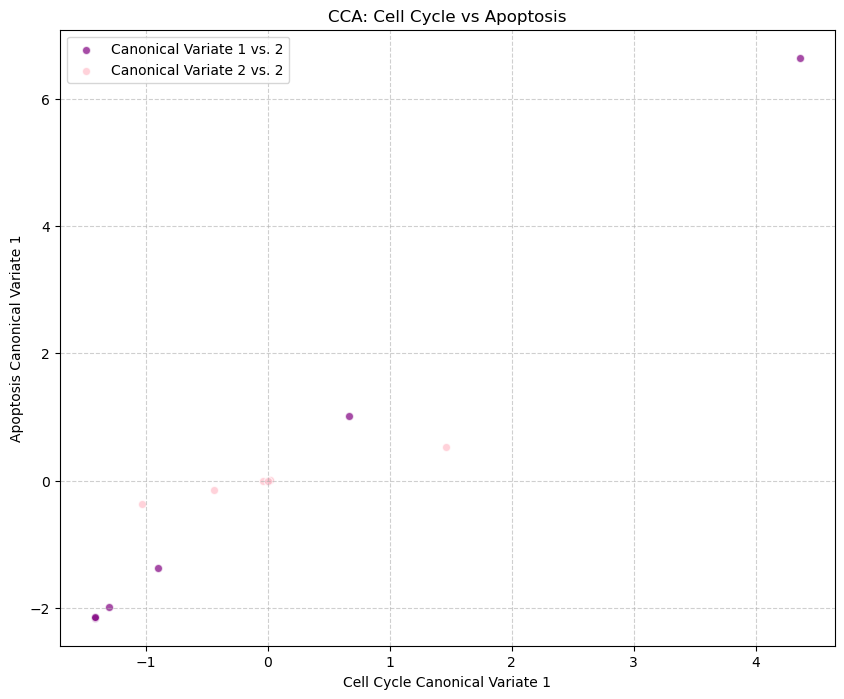

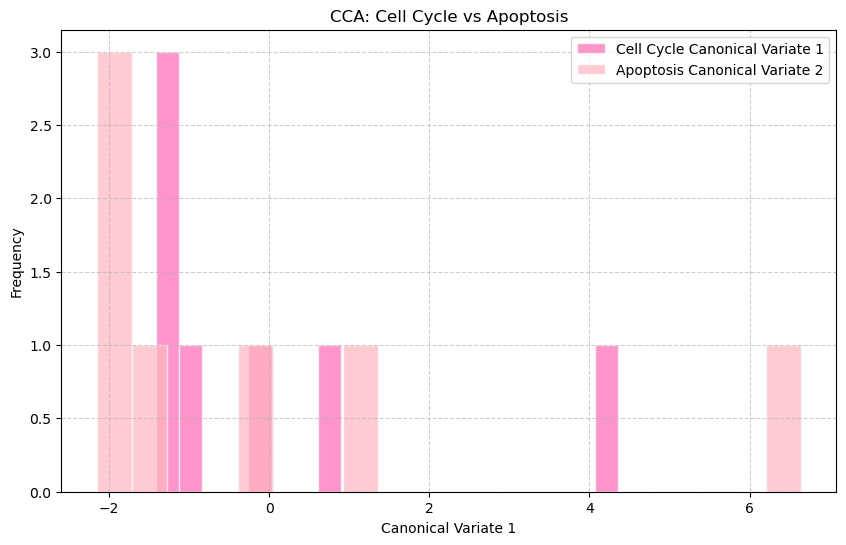

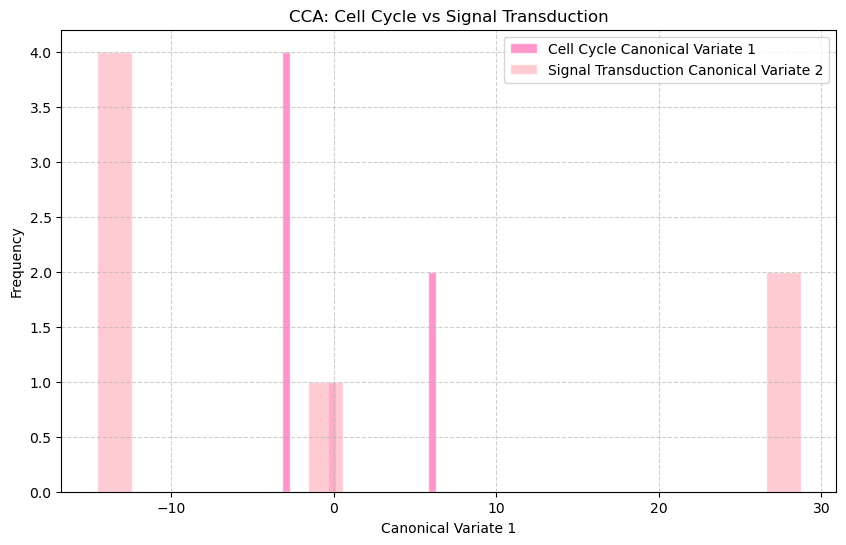

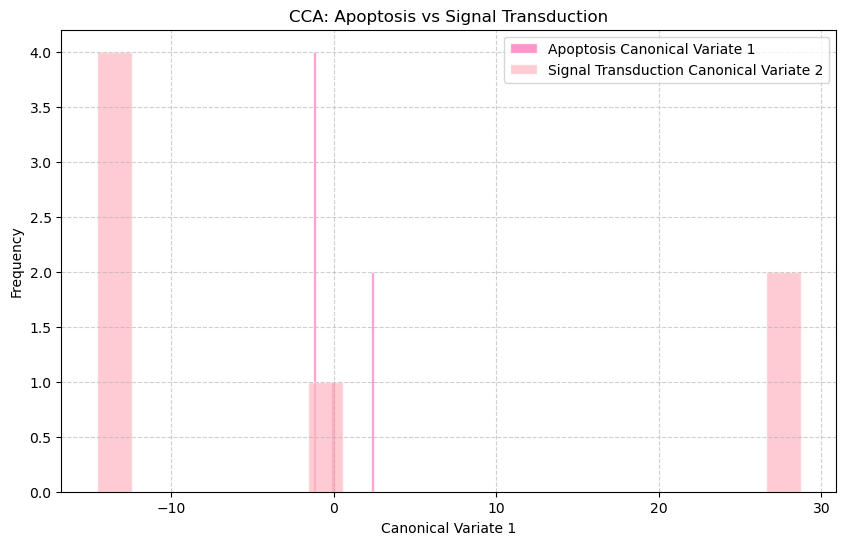

In [26]:
# Visualize results
plot_cca_compare(cca_12, X1_scaled, X2_scaled, "Cell Cycle", "Apoptosis")
# plot_cca_compare(cca_13, X1_scaled, X3_scaled, "Cell Cycle", "Signal Transduction")
# plot_cca_compare(cca_23, X2_scaled, X3_scaled, "Apoptosis", "Signal Transduction")

plot_cca_distribution(cca_12, X1_scaled, X2_scaled, "Cell Cycle", "Apoptosis")
plot_cca_distribution(cca_13, X1_scaled, X3_scaled, "Cell Cycle", "Signal Transduction")
plot_cca_distribution(cca_23, X2_scaled, X3_scaled, "Apoptosis", "Signal Transduction")

**CONCLUSION**
Correlation Strength:
1. The strongest correlation is between Cell Cycle and Signal Transduction (0.4371) (aligns with the known importance of dysregulated cell cycle control and signaling in cancer development)
2. The second strongest is between Cell Cycle and Apoptosis (0.2895)
3. The weakest correlation is between Apoptosis and Signal Transduction (0.2574)

All correlation scores are positive but relatively low -> moderate relationships between the pathways.

For all three comparisons, most of the canonical correlations are very close to 1.0 -> variables within each pathway are highly correlated with each other.
'nan' values in the last canonical correlation -> linear dependency in the data?


In [27]:
# Ana Carsi 2024
# Project: Review on Adaptive Canonical Correlation Analysis
# Description: This file contains the functions to perform Canonical Correlation Analysis (CCA) on the Stiefel Manifold.


import numpy as np
import matplotlib.pyplot as plt
from pymanopt import Problem
from pymanopt.manifolds import Stiefel, Product
from pymanopt.optimizers import TrustRegions
from pymanopt.function import Callable


def cca_on_stiefel(X: np.ndarray, Y: np.ndarray, k: int):
    """
    Perform CCA on the Stiefel Manifold.

    Parameters:
    -----------
    X : np.ndarray
        Data matrix of size n x p
    Y : np.ndarray
        Data matrix of size n x q
    k : int
        Number of canonical components to extract

    Returns:
    --------
    tuple
        Optimal points on the Stiefel manifold (U, V)
    """
    n, p = X.shape
    q = Y.shape[1]

    M1 = Stiefel(p, k)
    M2 = Stiefel(q, k)
    manifold = Product([M1, M2])

    def cost(point):
        U, V = point
        cost_value = -np.trace((U.T @ X.T @ Y @ V) @ (U.T @ X.T @ Y @ V).T)
        print(f"The cost function value is {cost_value}")
        return cost_value

    # Create a problem instance
    problem = Problem(manifold=manifold, cost=cost)
    optimizer = TrustRegions()

    Xopt = optimizer.run(problem).point

    return Xopt


def cca_with_tracking(X: np.ndarray, Y: np.ndarray, k: int, max_iter: int = 100):
    """
    Perform CCA on the Stiefel Manifold with tracking of objective values.

    Parameters:
    -----------
    X : np.ndarray
        Data matrix of size n x p
    Y : np.ndarray
        Data matrix of size n x q
    k : int
        Number of canonical components to extract
    max_iter : int, optional
        Maximum number of iterations (default is 100)

    Returns:
    --------
    list
        List of objective values over iterations
    """
    obj_values = []
    for _ in range(max_iter):
        Wx, Wy = cca_on_stiefel(X, Y, k)
        obj = -np.trace(np.dot(np.dot(Wx.T, X.T @ Y), Wy) @ np.dot(Wx.T, X.T @ Y), Wy).T
        obj_values.append(obj)

    return obj_values


def canonical_correlation_heatmap(X: np.ndarray, Y: np.ndarray, k: int):
    """
    Plot the canonical correlation heatmap.

    Parameters:
    -----------
    X : np.ndarray
        Data matrix of size n x p
    Y : np.ndarray
        Data matrix of size n x q
    k : int
        Number of canonical components to extract
    """
    Wx, Wy = cca_on_stiefel(X, Y, k)

    Ux = X @ Wx
    Uy = Y @ Wy

    corr_matrix = np.corrcoef(Ux.T, Uy.T)

    plt.figure(figsize=(10, 8))
    plt.imshow(corr_matrix, cmap="viridis")
    plt.colorbar()
    plt.xlabel

ImportError: cannot import name 'Callable' from 'pymanopt.function' (c:\Users\anaca\miniconda3\envs\cca_env_python\Lib\site-packages\pymanopt\function.py)